<a href="https://colab.research.google.com/github/Chichay317/Myers-Briggs-Personality-Prediction/blob/main/Personality_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
from bs4 import BeautifulSoup
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesClassifier

In [3]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
py.init_notebook_mode(connected=True)

In [5]:
# Datasets included in this repo:
# mbti_1.csv, Users.csv, ForumMessages.csv
# Original MBTI dataset sources:
# https://www.kaggle.com/datasets/datasnaek/mbti-type
# https://www.kaggle.com/datasets/vicdancastpinz/users-dataset-in-csv-format
# https://www.kaggle.com/datasets/bacharacherif/forummessagevotescsv

from google.colab import files
uploaded = files.upload()

Saving ForumMessages.csv to ForumMessages.csv
Saving mbti_1.csv to mbti_1.csv
Saving Users.csv to Users.csv


In [6]:
train = pd.read_csv('mbti_1.csv')
us = pd.read_csv('Users.csv')
ps = pd.read_csv("ForumMessages.csv", on_bad_lines="skip", engine="python")
mbti = {'I':'Introversion','E':'Extroversion','N':'Intuitions','S':'Sensing','T':'Thinking','F':'Feeling','J':'Judging','P':'Perceiving'}
#

In [7]:
train.shape

(8675, 2)

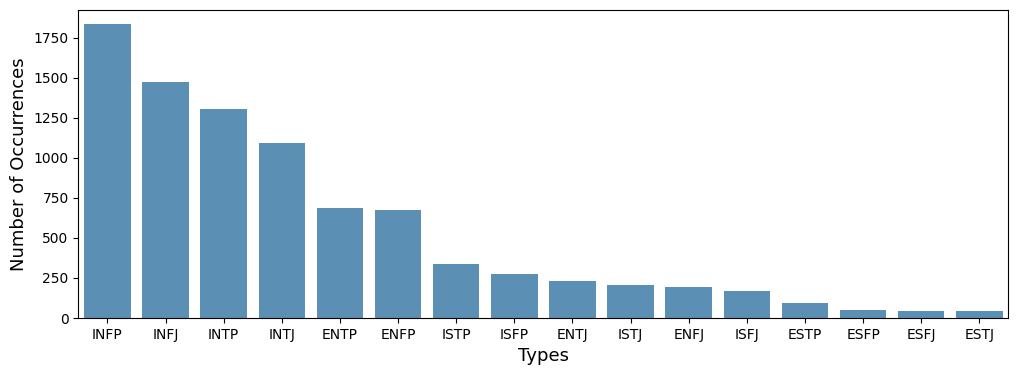

In [8]:
cnt_srs = train['type'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=13)
plt.xlabel('Types', fontsize=13)
plt.show()

In [9]:
ps['message'] = ps['message'].fillna('')

In [10]:
print(ps.columns)

Index(['message_id', 'user_id', 'timestamp', 'message'], dtype='object')


In [11]:
ps_join = ps.groupby('user_id')['message'].agg(lambda col: " ".join(col)).reset_index()

In [12]:
print(ps_join.head())

   user_id                                            message
0        1  http://www.youtube.com/watch?v=qsXHcwe3krw htt...
1        2  I'm finding the lack of me in these posts very...
2        3  Good one  _____   https://www.youtube.com/watc...
3        4  Dear INTP,   I enjoyed our conversation the ot...
4        5  You're fired. That's another silly misconcepti...


In [13]:
etc = ExtraTreesClassifier(n_estimators=20, max_depth=4, n_jobs = -1)
tfidf = TfidfVectorizer(ngram_range=(1,1), stop_words='english')
tsvd = TruncatedSVD(n_components=10)
model = Pipeline([('tfidfi', tfidf), ('tsvd1', tsvd), ('etc', etc)])

In [14]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [15]:
np.random.seed(1)

scoring = {'acc': 'accuracy', 'neg_log_loss': 'neg_log_loss', 'f1_micro': 'f1_micro'}
results = cross_validate(model, train['posts'], train['type'], cv=kfolds, scoring=scoring, n_jobs=-1)
#

In [16]:
print("CV Accuracy: {:0.4f} (+/- {:0.4f})".format(np.mean(results['test_acc']), np.std(results['test_acc'])))
print("CV F1: {:0.4f} (+/- {:0.4f})".format(np.mean(results['test_f1_micro']), np.std(results['test_f1_micro'])))
print("CV Logloss: {:0.4f} (+/- {:0.4f})".format(np.mean(results['test_neg_log_loss']), np.std(results['test_neg_log_loss'])))

CV Accuracy: 0.2861 (+/- 0.0126)
CV F1: 0.2861 (+/- 0.0126)
CV Logloss: -2.1453 (+/- 0.0104)


In [17]:
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r'', text)
    text = re.sub(r'http\S+', r'<URL>', text)
    return text

In [18]:
np.random.seed(1)

tfidf2 = CountVectorizer(ngram_range=(1,1), stop_words='english', lowercase=True, max_features=5000)

model_nb = Pipeline([('tfidf1', tfidf2), ('nb', MultinomialNB())])

results_nb = cross_validate(model_nb, train['posts'], train['type'], cv=kfolds, scoring=scoring, n_jobs=-1)

In [19]:
print("CV Accuracy: {:0.4f} (+/- {:0.4f})".format(np.mean(results_nb['test_acc']), np.std(results_nb['test_acc'])))
print("CV F1: {:0.4f} (+/- {:0.4f})".format(np.mean(results_nb['test_f1_micro']), np.std(results_nb['test_f1_micro'])))
print("CV Logloss: {:0.4f} (+/- {:0.4f})".format(np.mean(-1*results_nb['test_neg_log_loss']), np.std(-1*results_nb['test_neg_log_loss'])))

CV Accuracy: 0.5414 (+/- 0.0115)
CV F1: 0.5414 (+/- 0.0115)
CV Logloss: 7.2555 (+/- 0.4418)


In [20]:
np.random.seed(1)

tfidf2 = CountVectorizer(ngram_range=(1,1), stop_words='english', lowercase=True, max_features=5000)

model_lr = Pipeline([('tfidf1', tfidf2), ('lr', LogisticRegression(class_weight="balanced", C=0.005))])

results_lr = cross_validate(model_lr, train['posts'], train['type'], cv=kfolds, scoring=scoring, n_jobs=-1)

In [21]:
print("CV Accuracy: {:0.4f} (+/- {:0.4f})".format(np.mean(results_lr['test_acc']), np.std(results_lr['test_acc'])))
print("CV F1: {:0.4f} (+/- {:0.4f})".format(np.mean(results_lr['test_f1_micro']), np.std(results_lr['test_f1_micro'])))
print("CV Logloss: {:0.4f} (+/- {:0.4f})".format(np.mean(-1*results_lr['test_neg_log_loss']), np.std(-1*results_lr['test_neg_log_loss'])))

CV Accuracy: 0.6571 (+/- 0.0156)
CV F1: 0.6571 (+/- 0.0156)
CV Logloss: 1.2877 (+/- 0.0173)


In [22]:
train_sizes, train_scores, test_scores = learning_curve(model_lr, train['posts'], train['type'], train_sizes=np.linspace(.1, 1.0, 10), cv=kfolds, n_jobs=-1, scoring='f1_micro', random_state=1)

In [23]:
def plot_learning_curve(X, y, train_sizes, train_scores, test_scores, title='', ylim=None, figsize=(14,8)):
    plt.figure(figsize=figsize)
    plt.title(title)
    if ylim is not None:
      plt.ylim(*ylim)
    plt.xlabel("Training Examples")
    plt.ylabel("Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation Score")

    plt.legend(loc="best")
    return plt

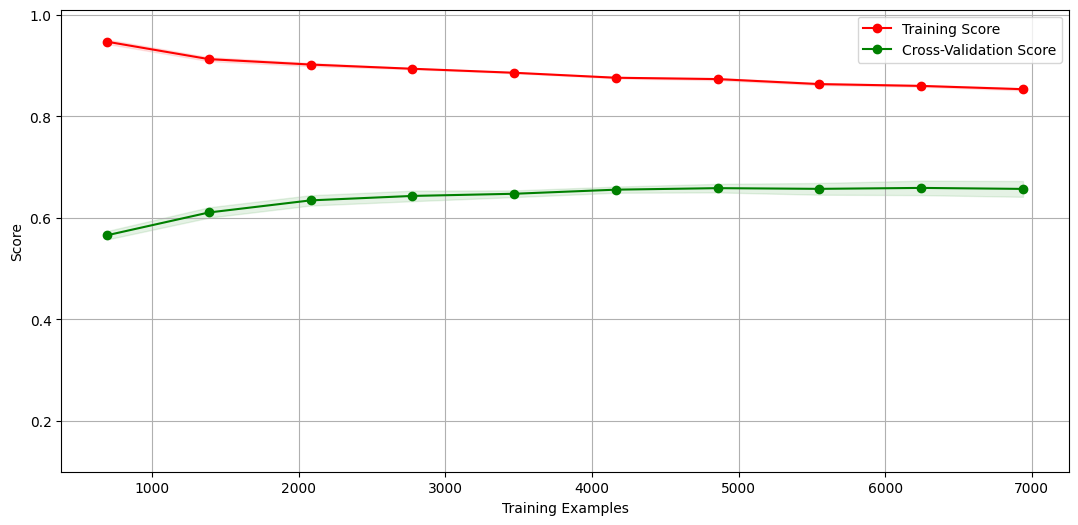

In [24]:
plot_learning_curve(train['posts'], train['type'], train_sizes, train_scores, test_scores, ylim=(0.1, 1.01), figsize=(13,6))

plt.show()

In [25]:
ps_join['clean_comments'] = ps_join['message'].apply(cleanText)

In [26]:
model_lr.fit(train['posts'], train['type'])
pred_all = model_lr.predict(ps_join['clean_comments'])

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Text(0.5, 0, 'Personality')

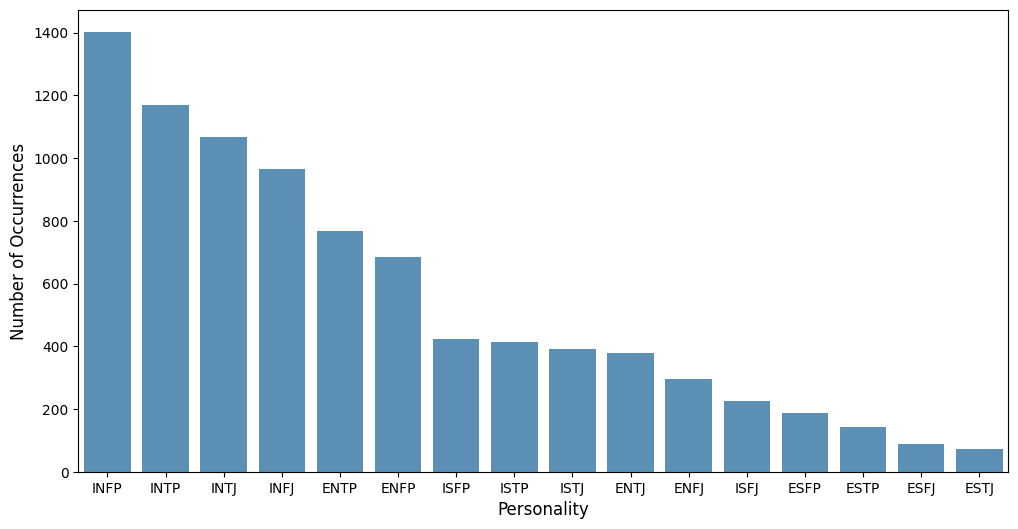

In [27]:
cnt_all = np.unique(pred_all, return_counts=True)

pred_df = pd.DataFrame({'Personality': cnt_all[0], 'Count': cnt_all[1]}, columns=['Personality', 'Count'], index=None)

pred_df.sort_values(by='Count', ascending=False, inplace=True)

plt.figure(figsize=(12,6))
sns.barplot(x=pred_df['Personality'], y=pred_df['Count'], alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Personality', fontsize=12)

In [28]:
pred_df['percent'] = pred_df['Count']/pred_df['Count'].sum()

In [29]:
pred_df['description'] = pred_df['Personality'].apply(lambda x: " ".join([mbti[l] for l in list(x)]))

In [30]:
pred_df

,Personality,Count,percent,description
9,INFP,1403,0.161729,Introversion Intuitions Feeling Perceiving
11,INTP,1168,0.134640,Introversion Intuitions Thinking Perceiving
10,INTJ,1068,0.123112,Introversion Intuitions Thinking Judging
8,INFJ,964,0.111124,Introversion Intuitions Feeling Judging
3,ENTP,769,0.088646,Extroversion Intuitions Thinking Perceiving
1,ENFP,684,0.078847,Extroversion Intuitions Feeling Perceiving
13,ISFP,424,0.048876,Introversion Sensing Feeling Perceiving
15,ISTP,415,0.047839,Introversion Sensing Thinking Perceiving
14,ISTJ,390,0.044957,Introversion Sensing Thinking Judging
2,ENTJ,380,0.043804,Extroversion Intuitions Thinking Judging


In [31]:
import plotly.graph_objs as go
import plotly.io as pio

pio.renderers.default = "colab"

labels = pred_df['description']
sizes = pred_df['percent'] * 100

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(title='Distribution of Personality Types')
fig = go.Figure(data=[trace], layout=layout)

fig.show()


In [36]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

X = vectorizer.fit_transform(train['posts'])

In [37]:
final_model = LogisticRegression(max_iter=1000)
final_model.fit(X, train['type'])

LogisticRegression(max_iter=1000)

In [39]:
new_text = ["I enjoy reading quietly at home."]

new_text_vec = vectorizer.transform([cleanText(t) for t in new_text])
prediction = final_model.predict(new_text_vec)

print("Predicted MBTI type:", prediction[0])

Predicted MBTI type: INTJ
